## Rumor Detection on Twitter Threads (Graph Theory Project YZV413E)

### Student Names

- **Ayah Hussein** — 150220917  
- **Oguzhan Celik** — 150210326

### Install Dependencies

In [ ]:
!pip install torch torchvision torchaudio

# PyTorch Geometric and extensions
!pip install torch-geometric

### Import Libraries

In [2]:
# Standard Library
import os
import ast
from collections import Counter, defaultdict

# Numerical & Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Graph Utilities
import networkx as nx

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE


# PyTorch 
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, CrossEntropyLoss

# PyTorch Geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GCN
from torch_geometric.nn.models import GCN, GAT
from torch_geometric.data import DataLoader



C:\Users\Oğuzhan ÇELİK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory Data Analysis

In [ ]:

# Config
# List of tuples: (Label File Path, Tree Directory Path)
datasets = [
    ("twitter15/label.txt", "twitter15/tree"),
    ("twitter16/label.txt", "twitter16/tree")
]

# Define the Binary Mapping
binary_map = {
    "non-rumor": "Non-Rumor",
    "false": "Rumor",
    "true": "Rumor",
    "unverified": "Rumor"
}

# Structure: { tweet_id: {'label': 'Rumor', 'dir': 'twitter15/tree'} }
label_info = {} 

# Process Both Label Files
for label_path, tree_dir in datasets:
    print(f"Reading {label_path}...")
    
    if not os.path.exists(label_path):
        print(f"  Error: {label_path} not found. Skipping.")
        continue

    count = 0
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) != 2: continue
            
            raw_label, tweet_id = parts[0], parts[1]
            
            if raw_label in binary_map:
                # Store label and the specific tree directory for this tweet
                label_info[tweet_id] = {
                    'label': binary_map[raw_label],
                    'dir': tree_dir
                }
                count += 1
    print(f"  -> Loaded {count} labels from {label_path}")

print(f"Total combined labels: {len(label_info)}")

data = []

print(f"Parsing trees for {len(label_info)} tweets...")

# Iterate through the combined dictionary
for tweet_id, info in label_info.items():
    binary_label = info['label']
    source_dir = info['dir']
    
    # Construct path using the specific directory for this tweet
    tree_path = os.path.join(source_dir, f"{tweet_id}.txt")
    
    if not os.path.exists(tree_path):
        continue
        
    try:
        with open(tree_path, 'r') as tree_f:
            lines = tree_f.readlines()
            
            # Metric A: Conversation Volume
            num_interactions = len(lines)
            
            # Metric B: Propagation Duration
            max_delay = 0.0
            
            for l in lines:
                split_arrow = l.strip().split('->')
                if len(split_arrow) < 2: continue
                
                try:
                    child_data = ast.literal_eval(split_arrow[1])
                    time_val = float(child_data[2])
                    
                    if time_val > max_delay: 
                        max_delay = time_val
                except (ValueError, SyntaxError, IndexError):
                    continue

            data.append({
                'label': binary_label,
                'interactions': num_interactions,
                'duration': max_delay,
                'dataset': source_dir.split('/')[0] 
            })
            
    except Exception as e:
        print(f"Error processing {tweet_id} in {source_dir}: {e}")
        continue

# Create the DataFrame
df = pd.DataFrame(data)
print(f"Processing complete. Combined DataFrame shape: {df.shape}")
print(df['label'].value_counts())


Reading twitter15/label.txt...
  -> Loaded 1490 labels from twitter15/label.txt
Reading twitter16/label.txt...
  -> Loaded 818 labels from twitter16/label.txt
Total combined labels: 2139
Parsing trees for 2139 tweets...
Processing complete. Combined DataFrame shape: (2139, 4)
label
Rumor        1560
Non-Rumor     579
Name: count, dtype: int64


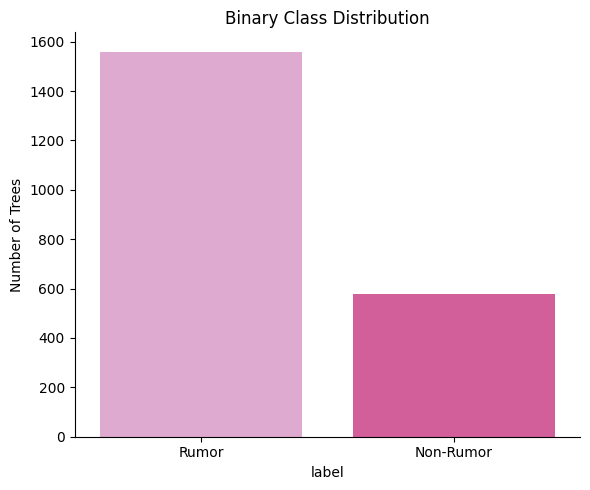

In [ ]:
# Bar chart to see the class distribution
plt.figure(figsize=(6, 5))

# colors
colors = ['#e6a2d4', '#e54c9b'] 

# Create Countplot
ax = sns.countplot(x='label', data=df, palette=colors)

# Styling
ax.set_title('Binary Class Distribution')
ax.set_ylabel('Number of Trees')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


#### As we can see in the graph the data is highly imbalanced with a ratio 1:3 for rumor:non-rumor and we will fiz this by assiging class weights later while calculating the loss.

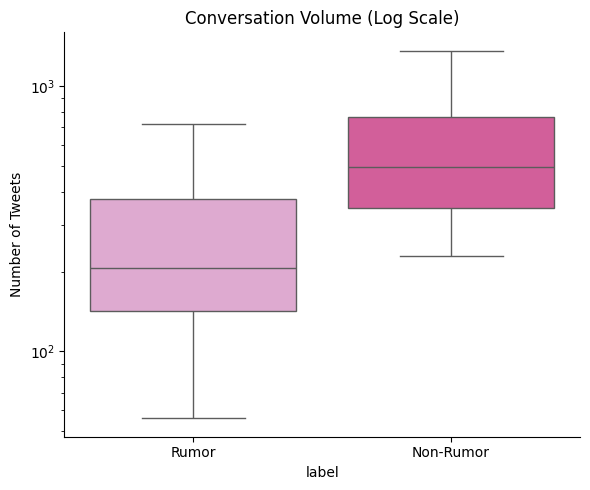

In [ ]:
# Boxplot to see the Conversation value distributions for rumor and non-rumor
plt.figure(figsize=(6, 5))
colors = ['#e6a2d4', '#e54c9b']

# Create Boxplot
ax = sns.boxplot(x='label', y='interactions', data=df, palette=colors, showfliers=False)

# Styling
ax.set_yscale('log')
ax.set_title('Conversation Volume (Log Scale)')
ax.set_ylabel('Number of Tweets')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


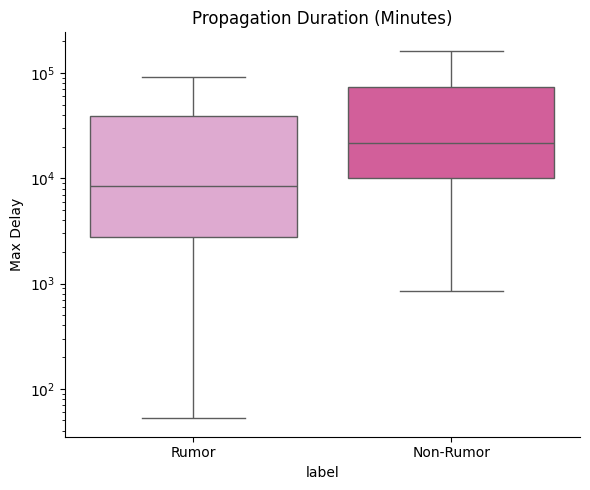

In [ ]:
# Boxplot to see the propogation duration distributions for rumor and non-rumor

plt.figure(figsize=(6, 5))
colors = ['#e6a2d4', '#e54c9b']
    
# Create Boxplot
ax = sns.boxplot(x='label', y='duration', data=df, palette=colors, showfliers=False)
    
# Styling
ax.set_yscale('log')
ax.set_title('Propagation Duration (Minutes)')
ax.set_ylabel('Max Delay')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.show()


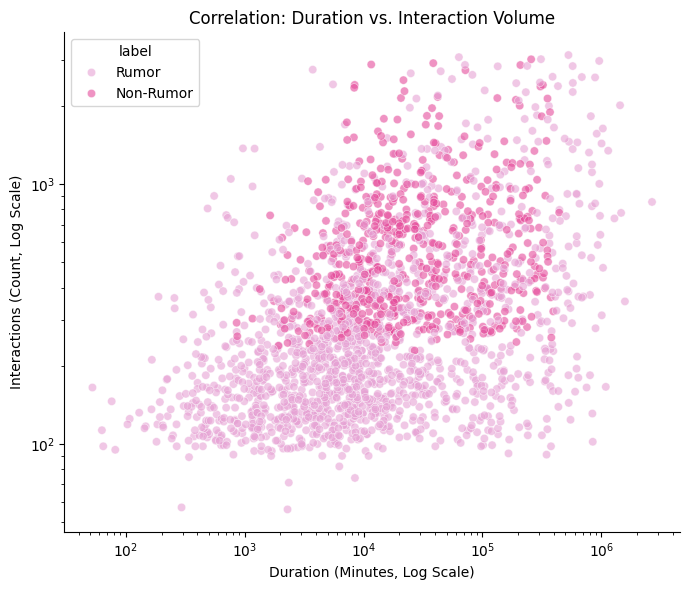

In [ ]:
# Scatter plot to check the correlation between Duration and interations number for rumor and non-rumor classes.
plt.figure(figsize=(7, 6))
colors = {'Rumor': '#e6a2d4', 'Non-Rumor': '#e54c9b'}

# Scatter plot with transparency
sns.scatterplot(x='duration', y='interactions', hue='label', data=df, palette=colors, alpha=0.6)

plt.xscale('log')
plt.yscale('log')
plt.title('Correlation: Duration vs. Interaction Volume')
plt.xlabel('Duration (Minutes, Log Scale)')
plt.ylabel('Interactions (Count, Log Scale)')

# Clean style
sns.despine()
plt.tight_layout()
plt.show()

In [27]:

def get_tree_metrics(file_path):

    nodes = set()
    children = set()
    out_degrees = defaultdict(int)
    max_time = 0.0
    
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('->')
            if len(parts) < 2: continue 

            # Parse lists 
            parent_data = ast.literal_eval(parts[0])
            child_data = ast.literal_eval(parts[1])
            
            u = parent_data[0]
            v = child_data[0]
            time_val = float(child_data[2])
            
            # Update Metrics
            nodes.add(u)
            nodes.add(v)
            children.add(v)
            out_degrees[u] += 1
            
            if time_val > max_time:
                max_time = time_val

    if not nodes: return None

    # Logic to find the Root: The node that is never a child
    roots = nodes - children
    root_id = list(roots)[0] if roots else None
    
    # Find Max Non-Root Out-Degree
    max_deg = -1
    max_deg_node = None
    
    for node, degree in out_degrees.items():
        if node == root_id: continue # Skip root
        
        if degree > max_deg:
            max_deg = degree
            max_deg_node = node
            
    return {
        'duration': max_time,
        'size': len(nodes),
        'max_inf': max_deg,
        'max_inf_node': max_deg_node
    }

def find_extremes():
    # Config
    datasets = [
        ("Twitter15", "twitter15/label.txt", "twitter15/tree"),
        ("Twitter16", "twitter16/label.txt", "twitter16/tree")
    ]
    
    # Trackers
    extremes = {
        'duration':  {'val': -1, 'id': None, 'set': None},
        'size':      {'val': -1, 'id': None, 'set': None},
        'influence': {'val': -1, 'id': None, 'node': None, 'set': None}
    }
    
    count = 0
    
    for name, label_path, tree_dir in datasets:
        print(f"Scanning {name}...")
        
        # Direct open label file
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split(':')
                if len(parts) != 2: continue
                
                tweet_id = parts[1]
                tree_path = os.path.join(tree_dir, f"{tweet_id}.txt")
                
                try:
                    m = get_tree_metrics(tree_path)
                except:
                    continue
                
                if not m: continue
                
                count += 1
                
                # Check Duration
                if m['duration'] > extremes['duration']['val']:
                    extremes['duration'] = {'val': m['duration'], 'id': tweet_id, 'set': name}
                    
                # Check Size
                if m['size'] > extremes['size']['val']:
                    extremes['size'] = {'val': m['size'], 'id': tweet_id, 'set': name}
                    
                # Check Influence
                if m['max_inf'] > extremes['influence']['val']:
                    extremes['influence'] = {
                        'val': m['max_inf'], 
                        'id': tweet_id, 
                        'node': m['max_inf_node'], 
                        'set': name
                    }

    # PRINT RESULTS
    print("\n" + "="*50)
    print(f"COMBINED EXTREMES (Scanned {count} trees)")
    print("="*50)
    
    print(f"1. LONGEST DURATION")
    print(f"   Time:    {extremes['duration']['val']:.2f} minutes")
    print(f"   Tree ID: {extremes['duration']['id']} ({extremes['duration']['set']})")
    
    print(f"\n2. LARGEST CONVERSATION")
    print(f"   Size:    {extremes['size']['val']} users")
    print(f"   Tree ID: {extremes['size']['id']} ({extremes['size']['set']})")
    
    print(f"\n3. HIGHEST NON-ROOT INFLUENCE")
    print(f"   Out-Deg: {extremes['influence']['val']} replies/retweets")
    print(f"   Tree ID: {extremes['influence']['id']} ({extremes['influence']['set']})")
    print(f"   Node ID: {extremes['influence']['node']}")
    print("="*50)

find_extremes()

Scanning Twitter15...
Scanning Twitter16...

COMBINED EXTREMES (Scanned 2308 trees)
1. LONGEST DURATION
   Time:    2675420.55 minutes
   Tree ID: 91728807081426944 (Twitter15)

2. LARGEST CONVERSATION
   Size:    3090 users
   Tree ID: 637868242560638980 (Twitter16)

3. HIGHEST NON-ROOT INFLUENCE
   Out-Deg: 2530 replies/retweets
   Tree ID: 527162170531151872 (Twitter15)
   Node ID: 95023423


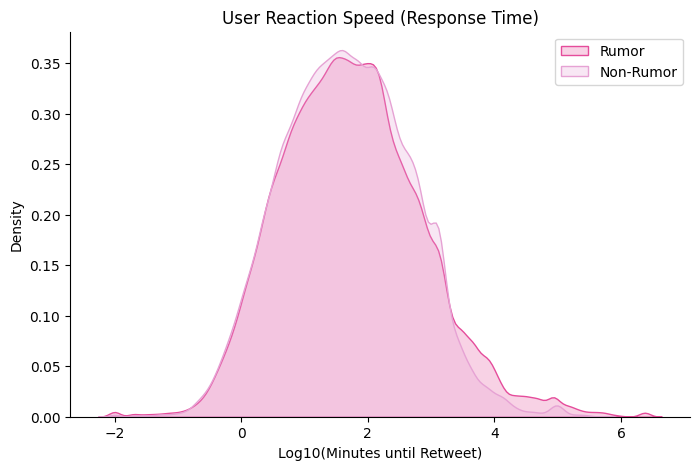

In [ ]:

def analyze_reaction_times(label_file, tree_dir):
    reactions = {'Rumor': [], 'Non-Rumor': []}
    binary_map = {"non-rumor": "Non-Rumor", "false": "Rumor", "true": "Rumor", "unverified": "Rumor"}
    
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) != 2: continue
            raw_label, tweet_id = parts[0], parts[1]
            if raw_label not in binary_map: continue
            
            cat = binary_map[raw_label]
            tree_path = os.path.join(tree_dir, f"{tweet_id}.txt")
            if not os.path.exists(tree_path): continue
            
            try:
                with open(tree_path, 'r') as tf:
                    for l in tf:
                        parts = l.strip().split('->')
                        if len(parts) < 2: continue
                        
                        # Extract times
                        # Format: ['UserID', 'TweetID', 'Time']
                        p_data = ast.literal_eval(parts[0])
                        c_data = ast.literal_eval(parts[1])
                        
                        t_parent = float(p_data[2])
                        t_child = float(c_data[2])
                        
                        diff = t_child - t_parent
                        if diff > 0: 
                            reactions[cat].append(diff)
            except: continue

    # PLOT (Histogram) ---
    plt.figure(figsize=(8, 5))
    
    # Log-transform for readability
    sns.kdeplot(np.log10(reactions['Rumor']), shade=True, color='#e54c9b', label='Rumor')
    sns.kdeplot(np.log10(reactions['Non-Rumor']), shade=True, color='#e6a2d4', label='Non-Rumor')
    
    plt.title('User Reaction Speed (Response Time)')
    plt.xlabel('Log10(Minutes until Retweet)')
    plt.ylabel('Density')
    plt.legend()
    sns.despine()
    plt.show()

analyze_reaction_times("twitter15/label.txt", "twitter15/tree")

This plot shows that there is no direct relation between the tweet being non-rumor or rumor and it being retweeted, On average, people click 'Retweet' relaively at the same speed regardless of whether it's a rumor or not. As we can observe after 100minutes usually the retweets number reaches a peak then start going down again.

Processing Twitter15...
Processing Twitter16...


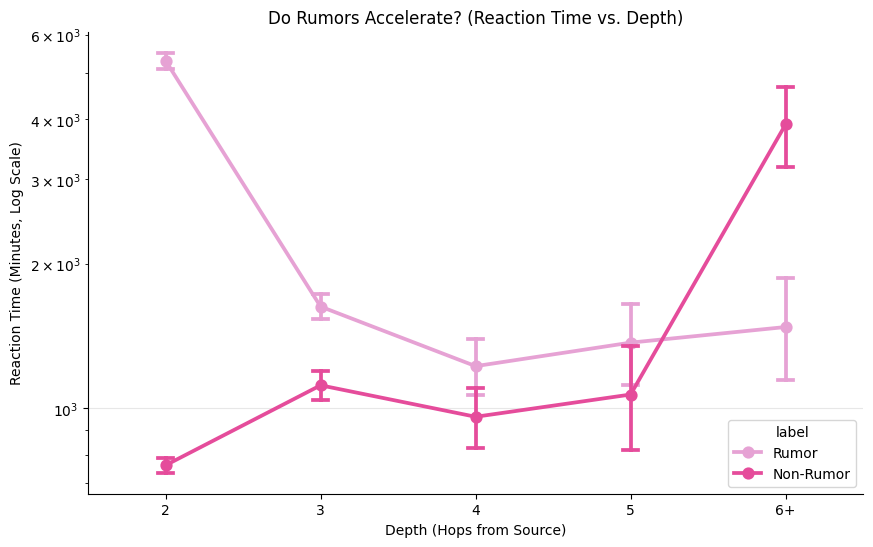

In [ ]:

def analyze_depth_reaction(datasets):
    """
    datasets: List of tuples [('Name', 'label_file', 'tree_dir'), ...]
    """
    data = []
    
    for name, label_file, tree_dir in datasets:
        print(f"Processing {name}...")
        
        # Load Labels
        labels = {}
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split(':')
                if len(parts) == 2:
                    labels[parts[1]] = parts[0] 
        
        # Process Trees
        for tweet_id, raw_label in labels.items():
            # Map labels
            if raw_label in ['false', 'true', 'unverified']:
                binary_label = 'Rumor'
            elif raw_label == 'non-rumor':
                binary_label = 'Non-Rumor'
            else:
                continue
                
            tree_path = os.path.join(tree_dir, f"{tweet_id}.txt")
            if not os.path.exists(tree_path): continue
            
            try:
                # Build Graph
                G = nx.DiGraph()
                times = {}
                
                with open(tree_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split('->')
                        if len(parts) < 2: continue
                        
                        # Parse
                        parent_data = ast.literal_eval(parts[0])
                        child_data = ast.literal_eval(parts[1])
                        
                        u, v = parent_data[0], child_data[0]
                        t_child = float(child_data[2])
                        t_parent = float(parent_data[2])
                        
                        G.add_edge(u, v)
                        times[v] = t_child
                        times[u] = t_parent # Ensure root has time too
                
                if len(G) == 0: continue
                
                # Find Root (node with in-degree 0)
                roots = [n for n in G.nodes() if G.in_degree(n) == 0]
                if not roots: continue
                root = roots[0]
                
                # Calculate Depth & Reaction Time for every node
                # shortest_path_length returns dictionary: {node: depth}
                depths = nx.shortest_path_length(G, source=root)
                
                for node, depth in depths.items():
                    if node == root: continue # Root has no reaction time
                    
                    # Find parent(s) to calculate immediate reaction time
                    preds = list(G.predecessors(node))
                    if not preds: continue
                    parent = preds[0]
                    
                    reaction_time = times[node] - times[parent]
                    
                    if reaction_time > 0: 
                        data.append({
                            'label': binary_label,
                            'depth': depth if depth <= 5 else '6+', # Group deep nodes
                            'reaction_time': reaction_time
                        })
                        
            except Exception as e:
                continue

    df = pd.DataFrame(data)
    
    # PLOTTING 
    plt.figure(figsize=(10, 6))
    
    # We use a pointplot (or lineplot) to show the TREND across depths
    # Log scale y-axis is crucial because reaction times vary wildly
    sns.pointplot(x='depth', y='reaction_time', hue='label', data=df, 
                  palette=['#e6a2d4', '#e54c9b'], errorbar=('ci', 95), capsize=0.1)
    
    plt.yscale('log')
    plt.title('Do Rumors Accelerate? (Reaction Time vs. Depth)')
    plt.xlabel('Depth (Hops from Source)')
    plt.ylabel('Reaction Time (Minutes, Log Scale)')
    plt.grid(True, axis='y', alpha=0.3)
    sns.despine()
    plt.show()

# Run with your combined data
datasets = [
    ("Twitter15", "twitter15/label.txt", "twitter15/tree"),
    ("Twitter16", "twitter16/label.txt", "twitter16/tree")
]
analyze_depth_reaction(datasets)

Non-rumors starts spreading fast, then fades away. While rumors start slow at first, then accelerates with time.

## Build The Graph

In [2]:
def build_graph_from_file(file_path):
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None

    G = nx.DiGraph()
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line: continue
                
                # Split the parent and child segments
                parts = line.split('->')
                
                if len(parts) == 2:
                    # Used ast.literal_eval to safely parse the string lists
                    # It handles the quotes automatically: "['uid', 'tid', '0.0']" -> list
                    parent_data = ast.literal_eval(parts[0].strip())
                    child_data = ast.literal_eval(parts[1].strip())
                    
                    # Extract Data
                    p_uid = str(parent_data[0])
                    p_tid = str(parent_data[1])
                    p_delay = float(parent_data[2])
                    
                    c_uid = str(child_data[0])
                    c_tid = str(child_data[1])
                    c_delay = float(child_data[2])
                    
                    # Construct Nodes
                    parent_node = (p_uid, p_tid)
                    child_node = (c_uid, c_tid)
                    
                    G.add_node(parent_node, delay=p_delay)
                    G.add_node(child_node, delay=c_delay)
                    
                    # Determine Relation
                    if p_tid == c_tid and p_uid != c_uid:
                        relation = 'retweet'
                    else:
                        relation = 'reply'
                        
                    G.add_edge(parent_node, child_node, label=relation)

        return G

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

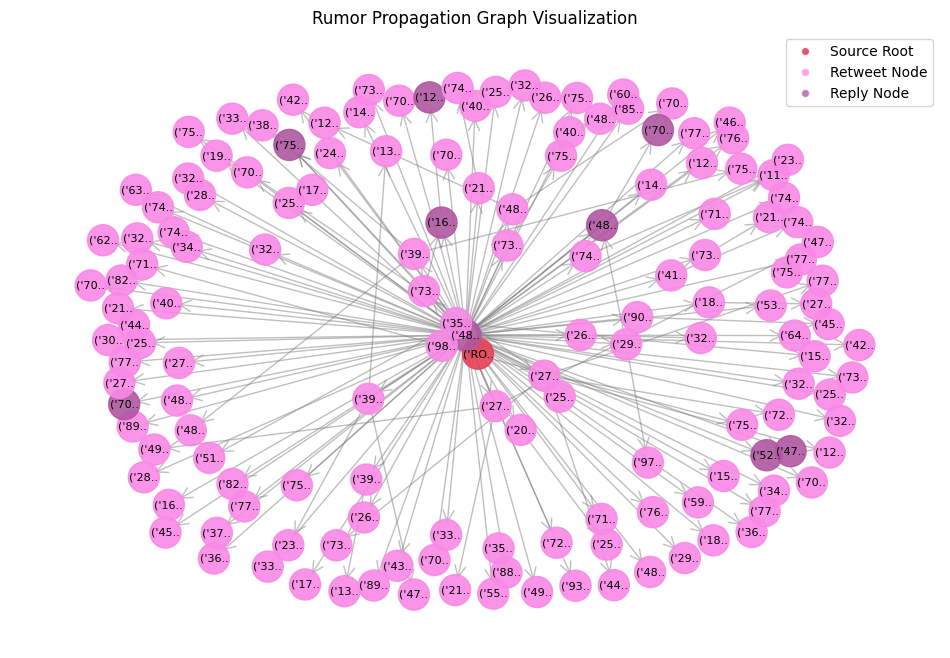

In [33]:
def visualize_propagation_graph(G):
    plt.figure(figsize=(12, 8))
    
    # k controls the distance between nodes (higher = further apart)
    pos = nx.spring_layout(G, k=0.1, iterations=20)
    
    root_node = [n for n, d in G.in_degree() if d == 0][0]

    node_colors = []
    for node in G.nodes():
        if node == root_node:
            node_colors.append("#E64255E6")    # Source Tweet/User
        elif list(G.in_edges(node, data=True))[0][2].get('label', '') == 'reply':
            node_colors.append("#B057A1C3") # Replies
        else:
            node_colors.append("#F989E6C3") # Retweets
            
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, 
                           node_color=node_colors, 
                           node_size=500, 
                           alpha=0.9)
    
    # Draw Edges (with arrows to show direction)
    nx.draw_networkx_edges(G, pos, 
                           arrowstyle='->', 
                           arrowsize=20, 
                           edge_color='gray', 
                           width=1.0,
                           alpha=0.5)
    
    # Draw Labels (User IDs)
    # We shorten IDs for readability in the plot
    labels = {node: str(node)[:4] + '..' for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#E64255E6', label='Source Root'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#F989E6C3', label='Retweet Node'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#B057A1C3', label='Reply Node'),
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Rumor Propagation Graph Visualization")
    plt.axis('off') 
    plt.show()

file_path = "twitter15/tree/778530869208190976.txt"
G = build_graph_from_file(file_path)

visualize_propagation_graph(G)

# Baselines

## Feature Extraction

In [ ]:
# Feature Extraction Function (Graph -> Single Row of Features)
def extract_tabular_features(G):
    """
    Aggregates node/edge metrics into a single dictionary of global features.
    """
    # Extract node attributes
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    delays = [data['delay'] for n, data in G.nodes(data=True)]
    
    # Calculate Max Depth
    # Find root (node with 0 in-degree) or default to first node
    roots = [n for n, d in G.in_degree() if d == 0]
    root = roots[0] if roots else list(G.nodes())[0]
    try:
        # Get all path lengths from root
        paths = nx.shortest_path_length(G, source=root)
        max_depth = max(paths.values()) if paths else 0
    except:
        max_depth = 0

    features = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'max_depth': max_depth,
        'max_in_degree': max(in_degrees) if in_degrees else 0,
        'max_out_degree': max(out_degrees) if out_degrees else 0,
        'max_reply_delay': max(delays) if delays else 0,
    }
    return features

# Data Loading Loop
def load_tabular_dataset(label_file, tree_dir):
    data_rows = []
    labels = []
    
    # Label Map
    label_map = {"non-rumor": 0, "false": 1, "true": 1, "unverified": 1}
    
    if not os.path.exists(label_file):
        print(f"Error: {label_file} not found.")
        return pd.DataFrame(), []

    print("Loading and extracting features from", tree_dir)
    
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) != 2: continue
            
            label_str, tweet_id = parts[0], parts[1]
            if label_str not in label_map: continue
            
            file_path = os.path.join(tree_dir, f"{tweet_id}.txt")
            
            # REUSE your existing function
            G = build_graph_from_file(file_path)
            
            if G is None or G.number_of_nodes() < 2:
                continue
            
            # Extract features for this graph
            feats = extract_tabular_features(G)
            data_rows.append(feats)
            labels.append(label_map[label_str])
            
    # Create Pandas DataFrame
    df = pd.DataFrame(data_rows)
    y = np.array(labels)
    
    return df, y

### Load Datasets

In [ ]:
weights = {0: 3, 1: 1} #Misclassfiyng a (non-Rumor) is 3 times more costly than misclassfying a Rumor. we did so because we have 25 : 75 rate for 0:1 classes.

# Define filenames
X_file = 'dataset/X_features_binary.pkl'
y_file = 'dataset/y_labels_binary.npy'

# 1. Check if files exist
if os.path.exists(X_file) and os.path.exists(y_file):
    print("Loading features")
    X = pd.read_pickle(X_file)
    y = np.load(y_file)
    print(f"Loaded {X.shape[0]} rows.")

else:
    X_15, y_15 = load_tabular_dataset("twitter15/label.txt", "twitter15/tree")
    X_16, y_16 = load_tabular_dataset("twitter16/label.txt", "twitter16/tree")

    X = pd.concat([X_15, X_16], ignore_index=True)
    y = np.concatenate([y_15, y_16])

    print(f"Dataset created with shape: {X.shape}")

    # Save
    X.to_pickle(X_file)
    np.save(y_file, y) # .npy is standard for numpy arrays

# B. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Loading features from disk
Loaded 2308 rows.


In [ ]:
# Define the mapping back to text for readability
# In the original dataset there are 4 classes we mapped classes 2,3 and 4 to one class (Rumor) and assigned class weight accordingly.
int_to_label = {
    0: "non-rumor",
    1: "rumor", 
}

# Extract labels from the training list
# data.y is a tensor, so we use .item() to get the integer
train_labels = [data.item() for data in y_train]

# Count instances
counts = Counter(train_labels)

# Print results
print(f"Total Training Graphs: {len(X_train)}")
print("-" * 30)
for label_idx in sorted(counts.keys()):
    label_name = int_to_label[label_idx]
    count = counts[label_idx]
    percentage = (count / len(X_train)) * 100
    print(f"{label_name:<12} (Class {label_idx}): {count} ({percentage:.1f}%)")

Total Training Graphs: 1846
------------------------------
non-rumor    (Class 0): 476 (25.8%)
rumor        (Class 1): 1370 (74.2%)


## Basline 1 : Support Vector Machine (SVM)

In [ ]:
svm_model = make_pipeline(
    StandardScaler(), 
    SVC(kernel='rbf', C=1.0, decision_function_shape='ovr', random_state=42, class_weight=weights)
)

print("Training SVM Classifier...")
svm_model.fit(X_train, y_train)

# 3. Predictions
y_pred = svm_model.predict(X_test)

print("SVM RESULTS")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("-" * 60)
# 4. Evaluation (With F1 Scores and 4-Class Support)
print("\n--- 4-Class SVM Classification Report ---")
class_names = ["Non-Rumor", "Rumor"]
print(classification_report(y_test, y_pred, target_names=class_names, digits=2))

Training SVM Classifier...
SVM RESULTS
Accuracy: 0.7489
------------------------------------------------------------

--- 4-Class SVM Classification Report ---
              precision    recall  f1-score   support

   Non-Rumor       0.47      0.91      0.62       103
       Rumor       0.97      0.70      0.81       359

    accuracy                           0.75       462
   macro avg       0.72      0.81      0.72       462
weighted avg       0.85      0.75      0.77       462



## Basline2 : Decision Tree

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=weights)

# Train
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)

print("RANDOM FOREST RESULTS")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("-" * 60)

class_names = ["Non-Rumor", "Rumor"]
print(classification_report(y_test, y_pred, target_names=class_names, digits=2))

# Feature Importance 
print("\nFeature Importance:")
importances = rf_model.feature_importances_
for name, importance in sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True):
    print(f"  {name:<20}: {importance:.4f}")

Training Random Forest...
RANDOM FOREST RESULTS
Accuracy: 0.8398
------------------------------------------------------------
              precision    recall  f1-score   support

   Non-Rumor       0.62      0.74      0.67       103
       Rumor       0.92      0.87      0.89       359

    accuracy                           0.84       462
   macro avg       0.77      0.80      0.78       462
weighted avg       0.85      0.84      0.84       462


Feature Importance:
  num_nodes           : 0.3106
  num_edges           : 0.2169
  max_out_degree      : 0.2148
  max_reply_delay     : 0.1680
  max_depth           : 0.0451
  max_in_degree       : 0.0446


# Modern NNs

## Tree Generation

In [3]:

def extract_node_features(G):
    """
    Extracts comprehensive node features.
    
    Total Features: 20
    """
    
    # Setup & Pre-calculations
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    node_mapping = {node: i for i, node in enumerate(nodes)}
    
    G_undir = G.to_undirected()
    
    roots = [n for n, d in G.in_degree() if d == 0]
    root = roots[0] if roots else nodes[0]

    # Calculate Metric Lists
    
    # Degree Metrics
    in_deg_list = [G.in_degree(n) for n in nodes]
    out_deg_list = [G.out_degree(n) for n in nodes]
    tot_deg_list = [G_undir.degree(n) for n in nodes]
    
    avg_neigh_deg = []
    max_neigh_deg = []
    for n in nodes:
        neighbors = list(G_undir.neighbors(n))
        if neighbors:
            degs = [G_undir.degree(nbr) for nbr in neighbors]
            avg_neigh_deg.append(np.mean(degs))
            max_neigh_deg.append(max(degs))
        else:
            avg_neigh_deg.append(0.0)
            max_neigh_deg.append(0.0)

    # Time, Propagation & Edge-to-Node Metrics
    global_delays = []
    local_delays = []
    is_reply_list = []   # New Feature
    is_retweet_list = [] # New Feature
    
    for n in nodes:
        # Time Features
        g_delay = G.nodes[n].get('delay', 0.0)
        global_delays.append(g_delay)
        
        preds = list(G.predecessors(n))
        if preds:
            parent = preds[0]
            
            # Local Delay
            p_delay = G.nodes[parent].get('delay', 0.0)
            local_delays.append(max(0, g_delay - p_delay))
            
            # Edge Type as Node Feature
            # We look at the edge from Parent -> Node
            edge_data = G.get_edge_data(parent, n)
            relation = edge_data.get('label', 'reply')
            
            if relation == 'reply':
                is_reply_list.append(1.0)
                is_retweet_list.append(0.0)
            else:
                is_reply_list.append(0.0)
                is_retweet_list.append(1.0)
        else:
            # Root node (no parent, no incoming edge)
            local_delays.append(0.0)
            is_reply_list.append(0.0)
            is_retweet_list.append(0.0)

    # Structural/Tree Features
    try:
        depths_dict = nx.shortest_path_length(G, source=root)
        depth_list = [depths_dict.get(n, 0) for n in nodes]
    except:
        depth_list = [0] * num_nodes

    is_root_list = [1.0 if n == root else 0.0 for n in nodes]
    is_leaf_list = [1.0 if G.out_degree(n) == 0 else 0.0 for n in nodes]
    
    subtree_list = []
    for n in nodes:
        try: subtree_list.append(len(nx.descendants(G, n)) + 1)
        except: subtree_list.append(1)

    # Centrality & Advanced Metrics
    def get_vec(metric_dict, default=0):
        return [metric_dict.get(n, default) for n in nodes]

    try: pr_dict = nx.pagerank(G, alpha=0.85)
    except: pr_dict = {}
    pr_list = get_vec(pr_dict)

    try: bt_dict = nx.betweenness_centrality(G_undir, normalized=True)
    except: bt_dict = {}
    bt_list = get_vec(bt_dict)

    try: cl_dict = nx.clustering(G_undir)
    except: cl_dict = {}
    cl_list = get_vec(cl_dict)

    try: close_dict = nx.closeness_centrality(G)
    except: close_dict = {}
    close_list = get_vec(close_dict)

    try:
        hubs, auths = nx.hits(G, max_iter=50)
        hub_list = get_vec(hubs)
        auth_list = get_vec(auths)
    except:
        hub_list, auth_list = [0] * num_nodes, [0] * num_nodes

    try: sq_dict = nx.square_clustering(G_undir)
    except: sq_dict = {}
    sq_list = get_vec(sq_dict)

    # Tensor Construction 
    
    def log_norm(l): 
        return torch.log(torch.tensor(l, dtype=torch.float).view(-1, 1) + 1.0)
    
    def raw_norm(l): 
        return torch.tensor(l, dtype=torch.float).view(-1, 1)

    feature_tensors = [
        # Time
        log_norm(global_delays), log_norm(local_delays),
        
        # Edge Type 
        raw_norm(is_reply_list), raw_norm(is_retweet_list),
        
        # Degree
        log_norm(in_deg_list), log_norm(out_deg_list), log_norm(tot_deg_list),
        log_norm(avg_neigh_deg), log_norm(max_neigh_deg),
        
        # Propagation
        log_norm(depth_list), raw_norm(is_root_list), raw_norm(is_leaf_list),
        log_norm(subtree_list),
        
        # Centrality
        raw_norm(pr_list), raw_norm(bt_list), raw_norm(cl_list),
        raw_norm(close_list), raw_norm(hub_list), raw_norm(auth_list),
        raw_norm(sq_list)
    ]

    x = torch.cat(feature_tensors, dim=1)

    x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    # Edge Index Only 
    edges = list(G.edges)
    if not edges:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_indices = [[node_mapping[u], node_mapping[v]] for u, v in edges]
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        
    return x, edge_index

In [5]:

def load_dataset(label_file, tree_dir, cache_file=None):
    if cache_file and os.path.exists(cache_file):
        print(f"Loading cached dataset from {cache_file}...")
        return torch.load(cache_file, weights_only=False)

    data_list = []
    label_map = {"non-rumor": 0, "false": 1, "true": 1, "unverified": 1}
    
    if not os.path.exists(label_file):
        return []

    print(f"Loading data from {label_file}...")
    
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split(':')
            if len(parts) != 2: continue
            label_str, tweet_id = parts[0], parts[1]
            if label_str not in label_map: continue
                
            file_path = os.path.join(tree_dir, f"{tweet_id}.txt")
            G = build_graph_from_file(file_path)
            
            if G is None or G.number_of_nodes() < 2: continue

            x, edge_index = extract_node_features(G)
            
            y = torch.tensor([label_map[label_str]], dtype=torch.long)
            
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
            
    print(f"Successfully loaded {len(data_list)} graphs.")

    if cache_file:
        print(f"Saving dataset to cache: {cache_file}")
        torch.save(data_list, cache_file)

    return data_list

# Load the Dataset

dataset_15 = load_dataset("twitter15/label.txt", "twitter15/tree", cache_file="dataset/twitter15_cache_binary.pt")
dataset_16 = load_dataset("twitter16/label.txt", "twitter16/tree", cache_file="dataset/twitter16_cache_binary.pt")

full_dataset = dataset_15 + dataset_16

# Extract Labels for Stratification
labels = [data.y.item() for data in full_dataset]

# First Split: Separate out the Test Set 
# We split 90% (Train+Val) and 10% (Test)
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    full_dataset, 
    labels, 
    test_size=0.1, 
    stratify=labels, 
    random_state=42
)

# Second Split: Separate Train (80%) and Val (10%)
train_data, val_data = train_test_split(
    train_val_data, 
    test_size=0.1111, 
    stratify=train_val_labels, 
    random_state=42
)

print(f"Dataset Sizes -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Create Loaders 
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Loading cached dataset from dataset/twitter15_cache_binary.pt...
Loading cached dataset from dataset/twitter16_cache_binary.pt...
Dataset Sizes -> Train: 1846, Val: 231, Test: 231


C:\Users\Oğuzhan ÇELİK\AppData\Local\Temp\ipykernel_36672\3328542160.py:72: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
C:\Users\Oğuzhan ÇELİK\AppData\Local\Temp\ipykernel_36672\3328542160.py:73: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
C:\Users\Oğuzhan ÇELİK\AppData\Local\Temp\ipykernel_36672\3328542160.py:74: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


## General Train-Test Logic

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_labels = [d.y.item() for d in train_loader.dataset]
classes = np.unique(train_labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

def train(loader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(loader, model, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    for data in loader:
        data = data.to(device)
        # Disable gradient calculation for testing to save memory
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)

            loss = criterion(out, data.y)
            total_loss += loss.item()

            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return total_loss / len(loader), correct / len(loader.dataset)

def run_train_test(model_name, model, optimizer, criterion, scheduler, epochs=100, return_history=False):
    print(f"\nStarting {model_name} Training...")
    best_val_acc = 0

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
    }

    for epoch in range(1, epochs+1):
        _ = train(train_loader, model, optimizer, criterion)
        train_loss, train_acc = test(train_loader, model, criterion)
        val_loss, val_acc = test(val_loader, model, criterion)
        
        if return_history:
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

        # Step the scheduler based on Validation Accuracy
        scheduler.step(val_acc)
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}_model.pth')
        
        print(f'Epoch: {epoch:03d} | Loss: {train_loss:.4f} | '
            f'Train: {train_acc:.4f} | Val: {val_acc:.4f} '
            f'(Best: {best_val_acc:.4f})')

    print("-" * 30)
    
    # Load best model for final test
    print("Loading best model for testing...")
    model.load_state_dict(torch.load(f'best_{model_name}_model.pth'))
    _, test_acc = test(test_loader, model, criterion)
    print(f'Final Test Accuracy (Best Model): {test_acc:.4f}')
    
    if return_history:
        return model, history
    return model

## Built-in GAT

In [ ]:

# Define the Wrapper for Graph Classification
class GATGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, heads=4):
        super().__init__()
        
        self.input_encoder = Sequential(
            Linear(in_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # The built-in GAT model
        self.gnn = GAT(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            out_channels=hidden_channels,
            dropout=0.5,
            heads=heads # GAT specific: Multi-head attention
        )
        
        # Final linear layer
        # Note: The built-in GAT model handles head concatenation/averaging 
        # such that the final output dimension matches 'out_channels' (which we set to hidden_channels).
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.input_encoder(x)
        # Get node embeddings from GAT
        x = self.gnn(x, edge_index)
        
        # Pool node embeddings
        x = global_mean_pool(x, batch)
        
        # Final classification
        return self.classifier(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GATGraphClassifier(
    in_channels=20, 
    hidden_channels=128,
    out_channels=2, 
    num_layers=3, 
    heads=4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, min_lr=0.00001
)

builtin_gat_model = run_train_test("gat", model, optimizer, criterion, scheduler)

#0.8355 wo seq wo weight
#0.8442 wo seq w weight
#0.8831 w seq w weight
#0.8615 w seq wo weight


Starting gat Training...
Epoch: 001 | Loss: 0.6315 | Train: 0.7069 | Val: 0.7100 (Best: 0.7100)
Epoch: 002 | Loss: 0.5362 | Train: 0.7790 | Val: 0.7879 (Best: 0.7879)
Epoch: 003 | Loss: 0.4910 | Train: 0.7952 | Val: 0.8095 (Best: 0.8095)
Epoch: 004 | Loss: 0.4571 | Train: 0.7801 | Val: 0.7749 (Best: 0.8095)
Epoch: 005 | Loss: 0.4748 | Train: 0.7654 | Val: 0.7662 (Best: 0.8095)
Epoch: 006 | Loss: 0.4454 | Train: 0.7996 | Val: 0.8052 (Best: 0.8095)
Epoch: 007 | Loss: 0.4492 | Train: 0.8131 | Val: 0.8182 (Best: 0.8182)
Epoch: 008 | Loss: 0.4372 | Train: 0.8088 | Val: 0.8268 (Best: 0.8268)
Epoch: 009 | Loss: 0.4344 | Train: 0.7692 | Val: 0.7879 (Best: 0.8268)
Epoch: 010 | Loss: 0.4171 | Train: 0.7947 | Val: 0.8052 (Best: 0.8268)
Epoch: 011 | Loss: 0.4166 | Train: 0.7958 | Val: 0.7922 (Best: 0.8268)
Epoch: 012 | Loss: 0.4338 | Train: 0.8180 | Val: 0.8268 (Best: 0.8268)
Epoch: 013 | Loss: 0.4437 | Train: 0.8142 | Val: 0.8268 (Best: 0.8268)
Epoch: 014 | Loss: 0.4549 | Train: 0.7941 | Val: 0.

## Built-in GCN

In [9]:

# Define the Wrapper for Graph Classification 
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()
        # The built-in GCN model
        self.input_encoder = Sequential(
            Linear(in_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        self.gnn = GCN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            out_channels=hidden_channels, # Output node embeddings of size 'hidden'
            dropout=dropout
        )
        # Final linear layer to go from embedding to binary classes
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.input_encoder(x)
        # Get node embeddings from the built-in GCN
        x = self.gnn(x, edge_index)
        
        # Pool node embeddings into a single graph embedding
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        # Final classification head
        return self.classifier(x)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCNGraphClassifier(
    in_channels=20, 
    hidden_channels=128, 
    out_channels=2, 
    num_layers=3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, min_lr=0.00001
)

builtin_gcn_model = run_train_test("gcn", model, optimizer, criterion, scheduler)

#0.8615 wo seq wo weight
#0.8788 w seq w weight
#0.8961 w seq wo weight
#0.7706 wo seq w weight


Starting gcn Training...
Epoch: 001 | Loss: 0.6002 | Train: 0.7373 | Val: 0.7316 (Best: 0.7316)
Epoch: 002 | Loss: 0.5280 | Train: 0.7454 | Val: 0.7576 (Best: 0.7576)
Epoch: 003 | Loss: 0.4815 | Train: 0.7936 | Val: 0.7706 (Best: 0.7706)
Epoch: 004 | Loss: 0.4584 | Train: 0.7254 | Val: 0.7229 (Best: 0.7706)
Epoch: 005 | Loss: 0.4570 | Train: 0.7719 | Val: 0.7879 (Best: 0.7879)
Epoch: 006 | Loss: 0.4410 | Train: 0.7687 | Val: 0.7792 (Best: 0.7879)
Epoch: 007 | Loss: 0.4660 | Train: 0.7665 | Val: 0.7835 (Best: 0.7879)
Epoch: 008 | Loss: 0.4206 | Train: 0.7606 | Val: 0.7792 (Best: 0.7879)
Epoch: 009 | Loss: 0.4139 | Train: 0.7481 | Val: 0.7662 (Best: 0.7879)
Epoch: 010 | Loss: 0.4156 | Train: 0.7600 | Val: 0.8095 (Best: 0.8095)
Epoch: 011 | Loss: 0.4299 | Train: 0.7860 | Val: 0.8139 (Best: 0.8139)
Epoch: 012 | Loss: 0.4040 | Train: 0.7654 | Val: 0.7922 (Best: 0.8139)
Epoch: 013 | Loss: 0.3970 | Train: 0.7757 | Val: 0.8052 (Best: 0.8139)
Epoch: 014 | Loss: 0.4463 | Train: 0.7801 | Val: 0.

## Built-in BiGCN

In [ ]:

class BiGCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.input_encoder = Sequential(
            Linear(in_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )

        # Top-Down Branch: Processes original edge directions
        self.td_gnn = GCN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            out_channels=hidden_channels,
            dropout=0.5
        )
        
        # Bottom-Up Branch: Processes reversed edge directions
        self.bu_gnn = GCN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            out_channels=hidden_channels,
            dropout=0.5
        )
        
        # Final classifier: Takes concatenated output from both branches
        # We multiply hidden_channels by 2 because we concatenate TD and BU results
        self.classifier = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.input_encoder(x)
        # TD Pass 
        x_td = self.td_gnn(x, edge_index)
        td_mean = global_mean_pool(x_td, batch)
        
        # Bottom-Up Branch (Reverse edges)
        bu_edge_index = edge_index[[1, 0]]
        x_bu = self.bu_gnn(x, bu_edge_index)
        bu_mean = global_mean_pool(x_bu, batch)
        
        # Concatenate all 4 pooling results
        x_combined = torch.cat([td_mean, bu_mean], dim=1)
        
        return self.classifier(x_combined)

In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiGCNGraphClassifier(
    in_channels=20, 
    hidden_channels=128, 
    out_channels=2, 
    num_layers=3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, min_lr=0.00001
)

builtin_bigcn_model = run_train_test("bigcn", model, optimizer, criterion, scheduler)

#0.8442 wo seq wo weight
#0.8615 w seq wo weight
#0.8571 w seq w weight
#0.8442 wo seq w weight


Starting bigcn Training...
Epoch: 001 | Loss: 0.5665 | Train: 0.8120 | Val: 0.8182 (Best: 0.8182)
Epoch: 002 | Loss: 0.4801 | Train: 0.7768 | Val: 0.7879 (Best: 0.8182)
Epoch: 003 | Loss: 0.4481 | Train: 0.7849 | Val: 0.7965 (Best: 0.8182)
Epoch: 004 | Loss: 0.4434 | Train: 0.7752 | Val: 0.7879 (Best: 0.8182)
Epoch: 005 | Loss: 0.4511 | Train: 0.8180 | Val: 0.8442 (Best: 0.8442)
Epoch: 006 | Loss: 0.4358 | Train: 0.7725 | Val: 0.7879 (Best: 0.8442)
Epoch: 007 | Loss: 0.4104 | Train: 0.8299 | Val: 0.8658 (Best: 0.8658)
Epoch: 008 | Loss: 0.3984 | Train: 0.7909 | Val: 0.8009 (Best: 0.8658)
Epoch: 009 | Loss: 0.4134 | Train: 0.7671 | Val: 0.7835 (Best: 0.8658)
Epoch: 010 | Loss: 0.4161 | Train: 0.7221 | Val: 0.7446 (Best: 0.8658)
Epoch: 011 | Loss: 0.4097 | Train: 0.7400 | Val: 0.7749 (Best: 0.8658)
Epoch: 012 | Loss: 0.3896 | Train: 0.8158 | Val: 0.8312 (Best: 0.8658)
Epoch: 013 | Loss: 0.3858 | Train: 0.8288 | Val: 0.8355 (Best: 0.8658)
Epoch: 014 | Loss: 0.4207 | Train: 0.7887 | Val: 

## Custom BiGCN

In [ ]:

# Helper Class: A Single Directional GCN Branch 
class GCNBranch(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        
        # First layer (Input -> Hidden)
        self.layers.append(GCNConv(in_channels, hidden_channels))
        
        # Hidden layers (Hidden -> Hidden)
        # We perform num_layers - 2 hidden operations here
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
            
        # Final GCN layer for the branch (Hidden -> Out/Embedding)
        self.layers.append(GCNConv(hidden_channels, out_channels))
        
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        # Iterate through all layers except the last one
        for i in range(len(self.layers) - 1):
            identity = x

            x = self.layers[i](x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)

            #Residual connection
            if x.shape == identity.shape:
                x = x + identity
        
        # Last layer
        x = self.layers[-1](x, edge_index)
        return x

# Main BiGCN Model 
class CustomBiGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super().__init__()

        self.input_encoder = Sequential(
            Linear(in_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )
        
        # Branch 1: Top-Down (TD)
        self.td_branch = GCNBranch(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            num_layers=num_layers
        )
        
        # Branch 2: Bottom-Up (BU)
        self.bu_branch = GCNBranch(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            num_layers=num_layers
        )

        # Classifier
        # Input size is hidden_channels * 2 because we concat TD and BU embeddings
        self.classifier = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.input_encoder(x)
        # Top-Down Branch 
        x_td = self.td_branch(x, edge_index)
        td_pool = global_mean_pool(x_td, batch)

        # Bottom-Up Branch 
        # Reverse edges for Bottom-Up
        bu_edge_index = edge_index[[1, 0]]
        
        x_bu = self.bu_branch(x, bu_edge_index)
        bu_pool = global_mean_pool(x_bu, batch)

        # Fusion & Classification 
        x_combined = torch.cat([td_pool, bu_pool], dim=1)
        
        out = self.classifier(x_combined)
        return out

In [135]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the Custom model
model = CustomBiGCN(
    in_channels=20, 
    hidden_channels=128, 
    out_channels=2, 
    num_layers=3
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, min_lr=0.00001
)

custom_bigcn_model = run_train_test("custom_bigcn", model, optimizer, criterion, scheduler)

# 0.8874 wo seq wo weight
# 0.8355 wo seq w weight
# 0.8745 w seq w weight
# 0.8874 w seq wo weight


Starting custom_bigcn Training...
Epoch: 001 | Loss: 0.6684 | Train: 0.8104 | Val: 0.8182 (Best: 0.8182)
Epoch: 002 | Loss: 0.4879 | Train: 0.7811 | Val: 0.7792 (Best: 0.8182)
Epoch: 003 | Loss: 0.4729 | Train: 0.8212 | Val: 0.8095 (Best: 0.8182)
Epoch: 004 | Loss: 0.4918 | Train: 0.8126 | Val: 0.8139 (Best: 0.8182)
Epoch: 005 | Loss: 0.4492 | Train: 0.7920 | Val: 0.8009 (Best: 0.8182)
Epoch: 006 | Loss: 0.4733 | Train: 0.7551 | Val: 0.7662 (Best: 0.8182)
Epoch: 007 | Loss: 0.4775 | Train: 0.8315 | Val: 0.8355 (Best: 0.8355)
Epoch: 008 | Loss: 0.4340 | Train: 0.7622 | Val: 0.7749 (Best: 0.8355)
Epoch: 009 | Loss: 0.4404 | Train: 0.8093 | Val: 0.8182 (Best: 0.8355)
Epoch: 010 | Loss: 0.4205 | Train: 0.8050 | Val: 0.8139 (Best: 0.8355)
Epoch: 011 | Loss: 0.4090 | Train: 0.8017 | Val: 0.7965 (Best: 0.8355)
Epoch: 012 | Loss: 0.4129 | Train: 0.7947 | Val: 0.8009 (Best: 0.8355)
Epoch: 013 | Loss: 0.4038 | Train: 0.7654 | Val: 0.7965 (Best: 0.8355)
Epoch: 014 | Loss: 0.3986 | Train: 0.8017 

# Evalution

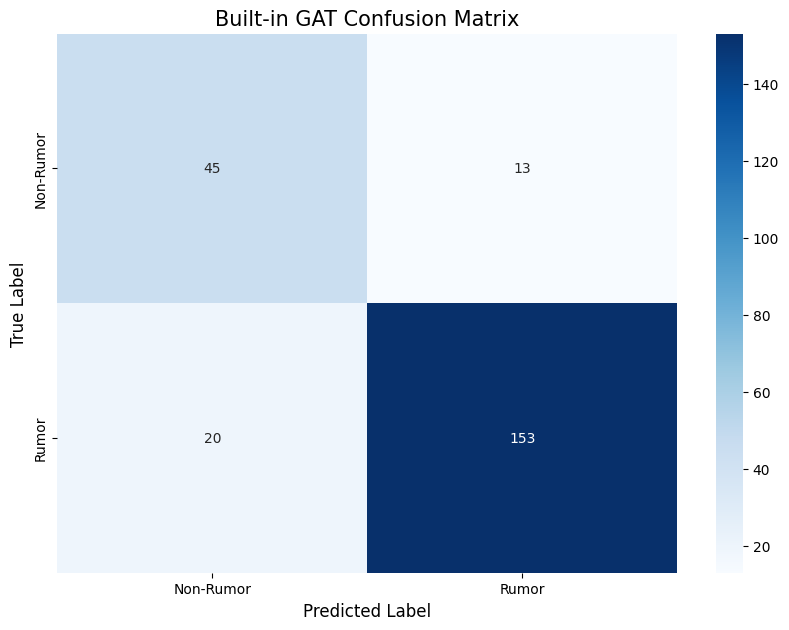

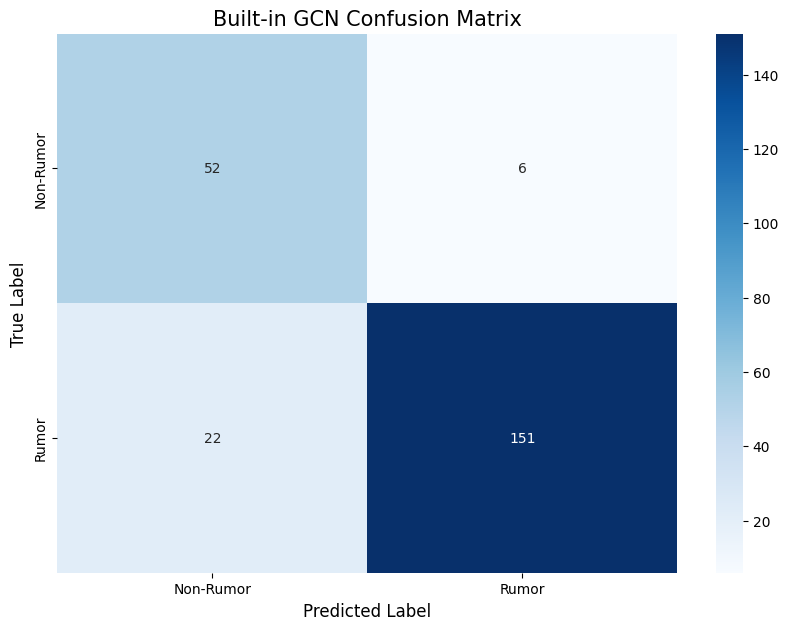

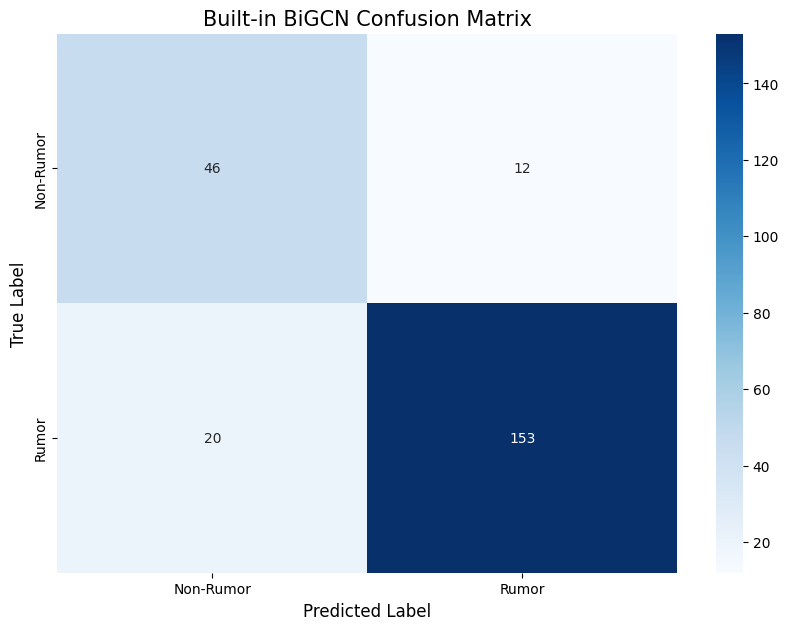

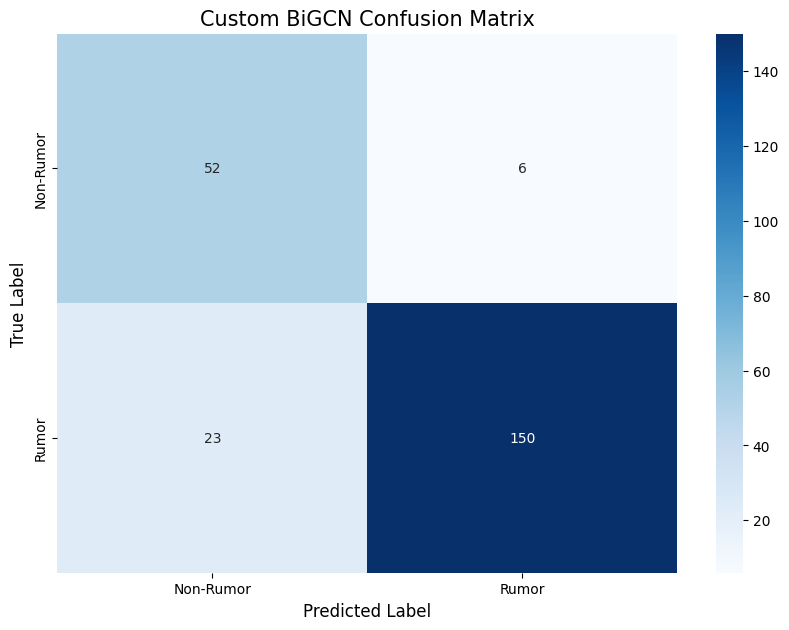

In [ ]:

def plot_confusion_matrix(model_name, model, loader, device):
    model.eval()
    
    y_true = []
    y_pred = []
    
    # Gather all predictions
    with torch.no_grad():
        for data in loader:
            data = data.to(device) 
            
            out = model(data.x, data.edge_index, data.batch)
            
            preds = out.argmax(dim=1)
            
            # Move back to CPU for numpy conversion
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Define Class Names
    class_names = ["Non-Rumor", "Rumor"]

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{model_name} Confusion Matrix', fontsize=15)
    plt.show()

# Passing the 'device' variable created earlier
plot_confusion_matrix("Built-in GAT", builtin_gat_model, test_loader, device)
plot_confusion_matrix("Built-in GCN", builtin_gcn_model, test_loader, device)
plot_confusion_matrix("Built-in BiGCN", builtin_bigcn_model, test_loader, device)
plot_confusion_matrix("Custom BiGCN", custom_bigcn_model, test_loader, device)

In [11]:
def print_model_performance(model_name, model, loader):
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device) 
            out = model(data.x, data.edge_index, data.batch)
            
            preds = out.argmax(dim=1)
            
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Define Class Names
    class_names = ["Non-Rumor", "Rumor"]

    # Print Report
    print(model_name)
    print("-"*60)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

In [ ]:

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60 + "\n")

print_model_performance("Built-in GAT", builtin_gat_model, test_loader)
print_model_performance("Built-in GCN", builtin_gcn_model, test_loader)
print_model_performance("Built-in BiGCN", builtin_bigcn_model, test_loader)
print_model_performance("Custom BiGCN", custom_bigcn_model, test_loader)


CLASSIFICATION REPORT

Built-in GAT
------------------------------------------------------------
Accuracy: 0.8571
              precision    recall  f1-score   support

   Non-Rumor       0.69      0.78      0.73        58
       Rumor       0.92      0.88      0.90       173

    accuracy                           0.86       231
   macro avg       0.81      0.83      0.82       231
weighted avg       0.86      0.86      0.86       231

Built-in GCN
------------------------------------------------------------
Accuracy: 0.8788
              precision    recall  f1-score   support

   Non-Rumor       0.70      0.90      0.79        58
       Rumor       0.96      0.87      0.92       173

    accuracy                           0.88       231
   macro avg       0.83      0.88      0.85       231
weighted avg       0.90      0.88      0.88       231

Built-in BiGCN
------------------------------------------------------------
Accuracy: 0.8615
              precision    recall  f1-score   s

Generating predictions...


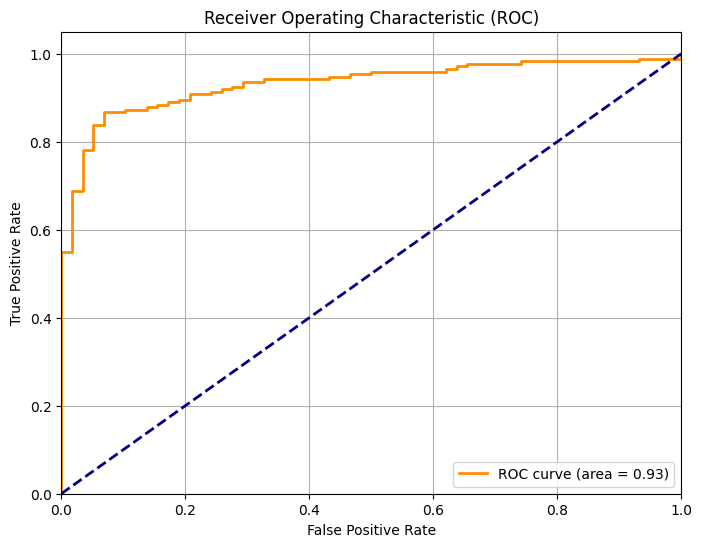

In [ ]:
y_true = []
y_scores = []

print("Generating predictions...")
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        
        out = builtin_gcn_model(data.x, data.edge_index, data.batch)
        
        probs = F.softmax(out, dim=1)[:, 1] 
        
        # Move to CPU and store
        y_scores.extend(probs.cpu().numpy())
        y_true.extend(data.y.cpu().numpy())

# 4. Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 5. Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Results and Visualizations

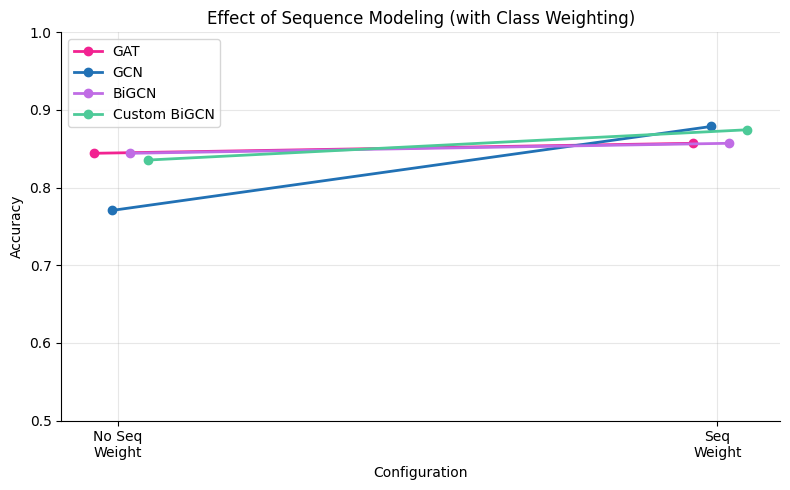

In [4]:

x_labels = ["No Seq\nWeight", "Seq\nWeight"]
base_x = np.array([0, 1])

results = {
    "GAT": [0.8442, 0.8571],
    "GCN": [0.7706, 0.8788],
    "BiGCN": [0.8442, 0.8571],
    "Custom BiGCN": [0.8355, 0.8745]
}

# Colors per model
colors = {
    "GAT": "#f22291",          
    "GCN": "#2171b5",        
    "BiGCN": "#c06ce5",        
    "Custom BiGCN": "#4dca98"  
}

plt.figure(figsize=(8, 5))

offsets = {
    "GAT": -0.04,
    "GCN": -0.01,
    "BiGCN": 0.02,
    "Custom BiGCN": 0.05
}

for model, scores in results.items():
    x = base_x + offsets[model]
    plt.plot(
        x,
        scores,
        marker='o',
        linewidth=2,
        label=model,
        color=colors[model]
    )

plt.xticks(base_x, x_labels)
plt.ylabel("Accuracy")
plt.xlabel("Configuration")
plt.title("Effect of Sequence Modeling (with Class Weighting)")
plt.ylim(0.5, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


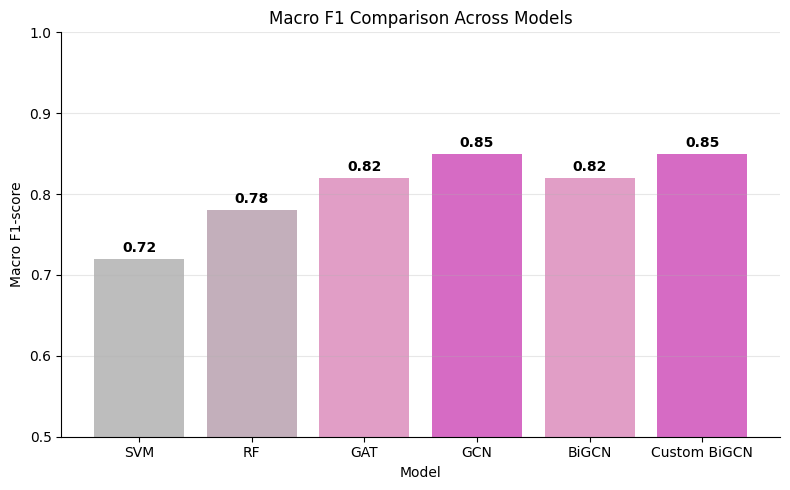

In [44]:

models = [
    "SVM",
    "RF",
    "GAT",
    "GCN",
    "BiGCN",
    "Custom BiGCN"
]

macro_f1 = [0.72, 0.78, 0.82, 0.85, 0.82, 0.85]

colors = [
    "#bdbdbd",   # SVM 
    "#C3AFBB",   # RF 
    "#e19ec6",   # GAT
    "#d66bc4",   # GCN (best)
    "#e19ec6",   # BiGCN
    "#d66bc4"    # Custom BiGCN (best)
]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, macro_f1, color=colors)

plt.ylabel("Macro F1-score")
plt.xlabel("Model")
plt.title("Macro F1 Comparison Across Models")
plt.ylim(0.5, 1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate values
for bar, val in zip(bars, macro_f1):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.005,
        f"{val:.2f}",
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold'
    )

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


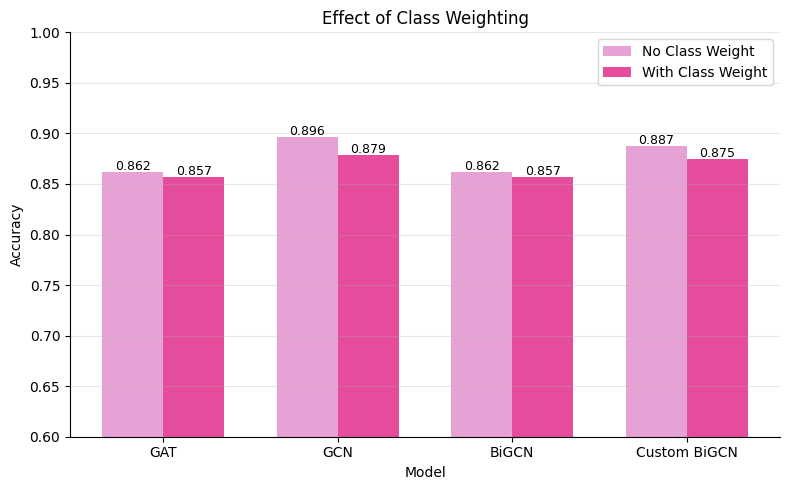

In [20]:

models = ["GAT", "GCN", "BiGCN", "Custom BiGCN"]

# With sequence, NO class weight
acc_no_weight = [0.8615, 0.8961, 0.8615, 0.8874]

# With sequence, WITH class weight
acc_weight = [0.8571, 0.8788, 0.8571, 0.8745]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))

plt.bar(
    x - width/2,
    acc_no_weight,
    width,
    label="No Class Weight",
    color="#e6a2d4"
)

plt.bar(
    x + width/2,
    acc_weight,
    width,
    label="With Class Weight",
    color="#e54c9b"
)

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Effect of Class Weighting")
plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Clean axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate values
for i, (nw, w) in enumerate(zip(acc_no_weight, acc_weight)):
    plt.text(i - width/2, nw + 0.002, f"{nw:.3f}", ha='center', fontsize=9)
    plt.text(i + width/2, w + 0.002, f"{w:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


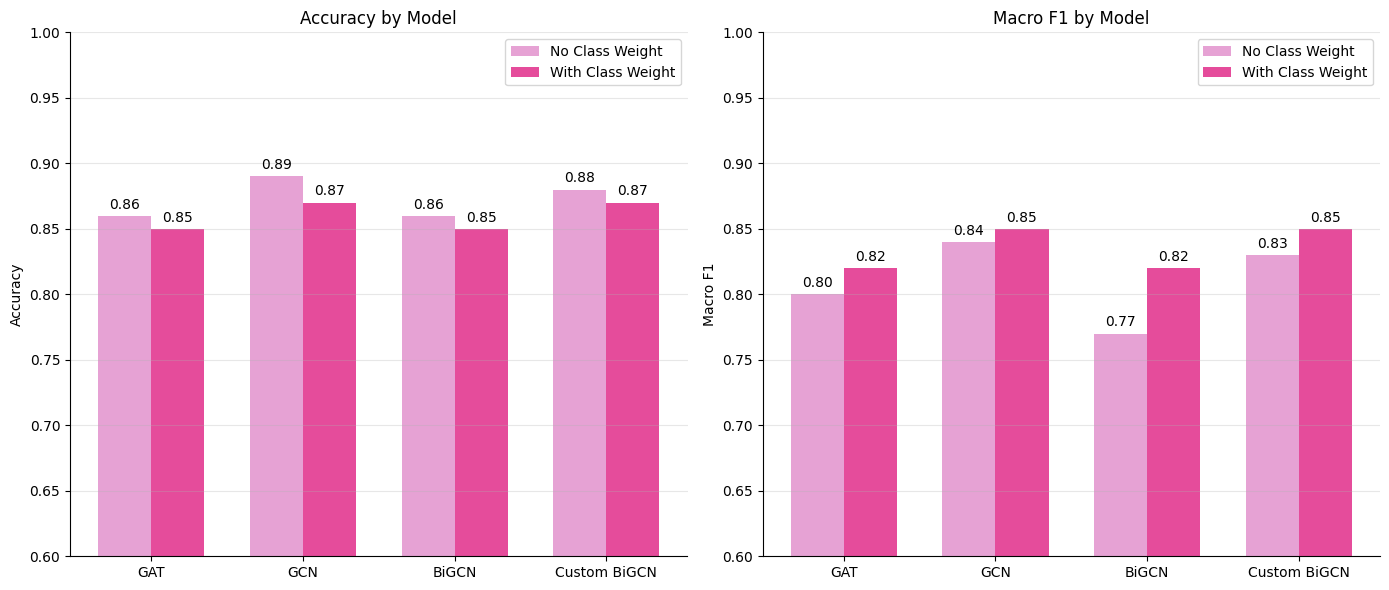

In [ ]:


# No class weight
acc_no_weight = [0.86, 0.89, 0.86, 0.88]
f1_no_weight = [0.8, 0.84, 0.77, 0.83]

# With class weight
acc_weight = [0.85, 0.87, 0.85, 0.87]
f1_weight = [0.82, 0.85, 0.82, 0.85]

models = ["GAT", "GCN", "BiGCN", "Custom BiGCN"]

x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax1 = axes[0]
rects1 = ax1.bar(x - width/2, acc_no_weight, width, label='No Class Weight', color='#e6a2d4')
rects2 = ax1.bar(x + width/2, acc_weight, width, label='With Class Weight', color='#e54c9b')

ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylim(0.6,1)
ax1.legend()
ax1.bar_label(rects1, fmt='%.2f', padding=3)
ax1.bar_label(rects2, fmt='%.2f', padding=3)
ax1.grid(axis='y', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Macro F1
ax2 = axes[1]
rects3 = ax2.bar(x - width/2, f1_no_weight, width, label='No Class Weight', color='#e6a2d4')
rects4 = ax2.bar(x + width/2, f1_weight, width, label='With Class Weight', color='#e54c9b')

ax2.set_ylabel('Macro F1')
ax2.set_title('Macro F1 by Model')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_ylim(0.6,1)
ax2.legend()

ax2.bar_label(rects3, fmt='%.2f', padding=3)
ax2.bar_label(rects4, fmt='%.2f', padding=3)
ax2.grid(axis='y', alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Hyperparameter Experiments

### Hidden Layers


--- Starting training with #Layer = 16 ---

Starting gcn_hidden16 Training...
Epoch: 001 | Loss: 0.6903 | Train: 0.2508 | Val: 0.2511 (Best: 0.2511)
Epoch: 002 | Loss: 0.6312 | Train: 0.5959 | Val: 0.5801 (Best: 0.5801)
Epoch: 003 | Loss: 0.5057 | Train: 0.7416 | Val: 0.7316 (Best: 0.7316)
Epoch: 004 | Loss: 0.4599 | Train: 0.7183 | Val: 0.7186 (Best: 0.7316)
Epoch: 005 | Loss: 0.4297 | Train: 0.7172 | Val: 0.7273 (Best: 0.7316)
Epoch: 006 | Loss: 0.4271 | Train: 0.7465 | Val: 0.7446 (Best: 0.7446)
Epoch: 007 | Loss: 0.4114 | Train: 0.7384 | Val: 0.7489 (Best: 0.7489)
Epoch: 008 | Loss: 0.4109 | Train: 0.7470 | Val: 0.7619 (Best: 0.7619)
Epoch: 009 | Loss: 0.4154 | Train: 0.7281 | Val: 0.7489 (Best: 0.7619)
Epoch: 010 | Loss: 0.4049 | Train: 0.7611 | Val: 0.7706 (Best: 0.7706)
Epoch: 011 | Loss: 0.4159 | Train: 0.7205 | Val: 0.7532 (Best: 0.7706)
Epoch: 012 | Loss: 0.3996 | Train: 0.7427 | Val: 0.7662 (Best: 0.7706)
Epoch: 013 | Loss: 0.3945 | Train: 0.7530 | Val: 0.7662 (Best: 0.7706

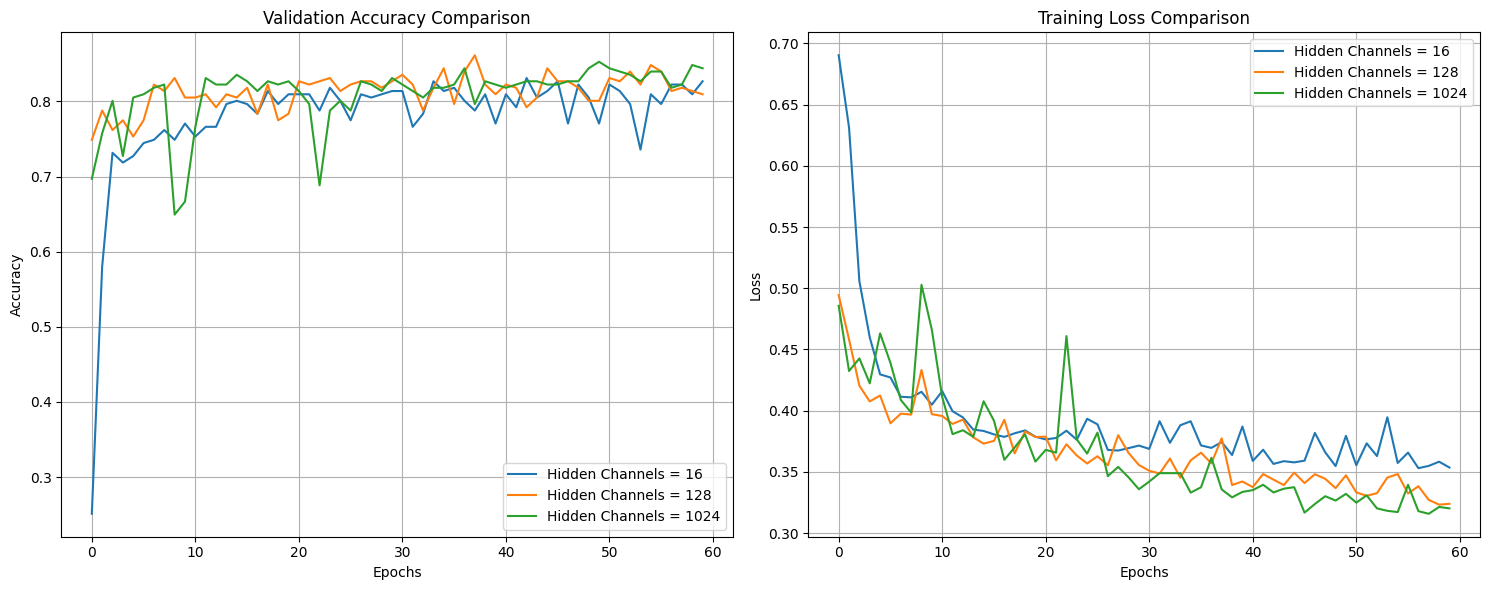

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_values = [16, 128, 1024]

hid_histories = {}
models = {}

# Iterate and Train
for hid in hidden_values:
    print(f"\n--- Starting training with #Layer = {hid} ---")
    model = GCNGraphClassifier(
        in_channels=20, 
        hidden_channels=hid, 
        out_channels=2, 
        num_layers=3
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=0.00001
    )

    models[f"hidden{hid}"] , hid_histories[f"Hidden Channels = {hid}"] = run_train_test(f"gcn_hidden{hid}", model, optimizer, criterion, scheduler, epochs=60, return_history=True)

print("-"*30)
for model_name, _model in models.items():
    print_model_performance(model_name, _model, test_loader)

# Plotting the Results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name, history in hid_histories.items():
    plt.plot(history['val_acc'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in hid_histories.items():
    plt.plot(history['train_loss'], label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Learning Rate


--- Starting training with Learning Rate = 0.01 ---

Starting gcn_lr0.01 Training...
Epoch: 001 | Loss: 0.5132 | Train: 0.6820 | Val: 0.6840 (Best: 0.6840)
Epoch: 002 | Loss: 0.4294 | Train: 0.7714 | Val: 0.7792 (Best: 0.7792)
Epoch: 003 | Loss: 0.6240 | Train: 0.4350 | Val: 0.4242 (Best: 0.7792)
Epoch: 004 | Loss: 0.4352 | Train: 0.7969 | Val: 0.7965 (Best: 0.7965)
Epoch: 005 | Loss: 0.4027 | Train: 0.7622 | Val: 0.7662 (Best: 0.7965)
Epoch: 006 | Loss: 0.3962 | Train: 0.7849 | Val: 0.8009 (Best: 0.8009)
Epoch: 007 | Loss: 0.4521 | Train: 0.6972 | Val: 0.7229 (Best: 0.8009)
Epoch: 008 | Loss: 0.3943 | Train: 0.8055 | Val: 0.8095 (Best: 0.8095)
Epoch: 009 | Loss: 0.3709 | Train: 0.7920 | Val: 0.8052 (Best: 0.8095)
Epoch: 010 | Loss: 0.3899 | Train: 0.8055 | Val: 0.8052 (Best: 0.8095)
Epoch: 011 | Loss: 0.4289 | Train: 0.6918 | Val: 0.7013 (Best: 0.8095)
Epoch: 012 | Loss: 0.3926 | Train: 0.8072 | Val: 0.8182 (Best: 0.8182)
Epoch: 013 | Loss: 0.5850 | Train: 0.6111 | Val: 0.6364 (Best:

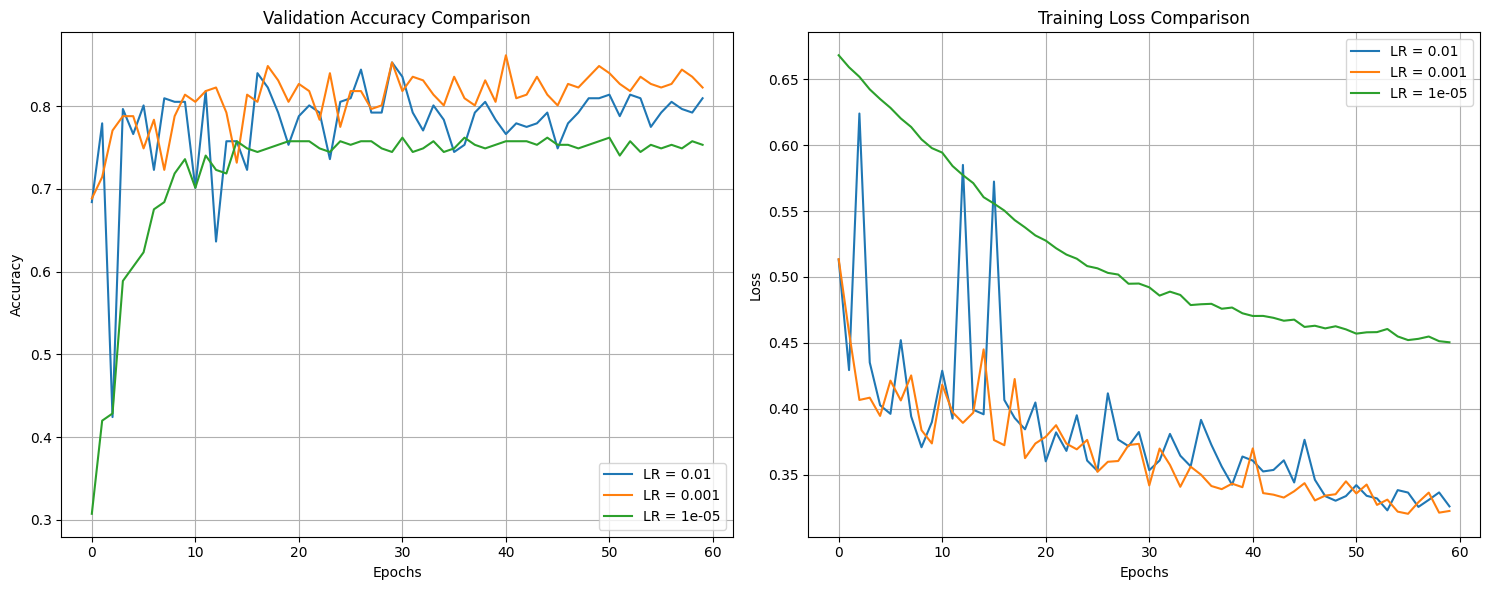

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr_values = [1e-2, 1e-3, 1e-5]

lr_histories = {}
models = {}

# Iterate and Train
for lr in lr_values:
    print(f"\n--- Starting training with Learning Rate = {lr} ---")
    model = GCNGraphClassifier(
        in_channels=20, 
        hidden_channels=128, 
        out_channels=2, 
        num_layers=3
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=0.00001
    )

    models[f"lr{lr}"] , lr_histories[f"LR = {lr}"] = run_train_test(f"gcn_lr{lr}", model, optimizer, criterion, scheduler, epochs=60, return_history=True)

print("-"*30)
for model_name, _model in models.items():
    print_model_performance(model_name, _model, test_loader)

# Plotting the Results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name, history in lr_histories.items():
    plt.plot(history['val_acc'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in lr_histories.items():
    plt.plot(history['train_loss'], label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Optimizer


--- Starting training with Optimizer = SGD ---

Starting gcn_SGD Training...
Epoch: 001 | Loss: 0.6139 | Train: 0.4902 | Val: 0.4935 (Best: 0.4935)
Epoch: 002 | Loss: 0.5584 | Train: 0.7351 | Val: 0.7273 (Best: 0.7273)
Epoch: 003 | Loss: 0.4635 | Train: 0.7811 | Val: 0.7662 (Best: 0.7662)
Epoch: 004 | Loss: 0.4400 | Train: 0.7633 | Val: 0.7619 (Best: 0.7662)
Epoch: 005 | Loss: 0.4430 | Train: 0.7660 | Val: 0.7576 (Best: 0.7662)
Epoch: 006 | Loss: 0.4778 | Train: 0.6869 | Val: 0.6797 (Best: 0.7662)
Epoch: 007 | Loss: 0.4229 | Train: 0.7752 | Val: 0.7706 (Best: 0.7706)
Epoch: 008 | Loss: 0.4365 | Train: 0.7876 | Val: 0.7749 (Best: 0.7749)
Epoch: 009 | Loss: 0.4282 | Train: 0.7855 | Val: 0.7922 (Best: 0.7922)
Epoch: 010 | Loss: 0.4393 | Train: 0.7839 | Val: 0.7749 (Best: 0.7922)
Epoch: 011 | Loss: 0.4208 | Train: 0.7546 | Val: 0.7662 (Best: 0.7922)
Epoch: 012 | Loss: 0.4105 | Train: 0.7828 | Val: 0.7835 (Best: 0.7922)
Epoch: 013 | Loss: 0.4114 | Train: 0.7904 | Val: 0.8009 (Best: 0.8009)

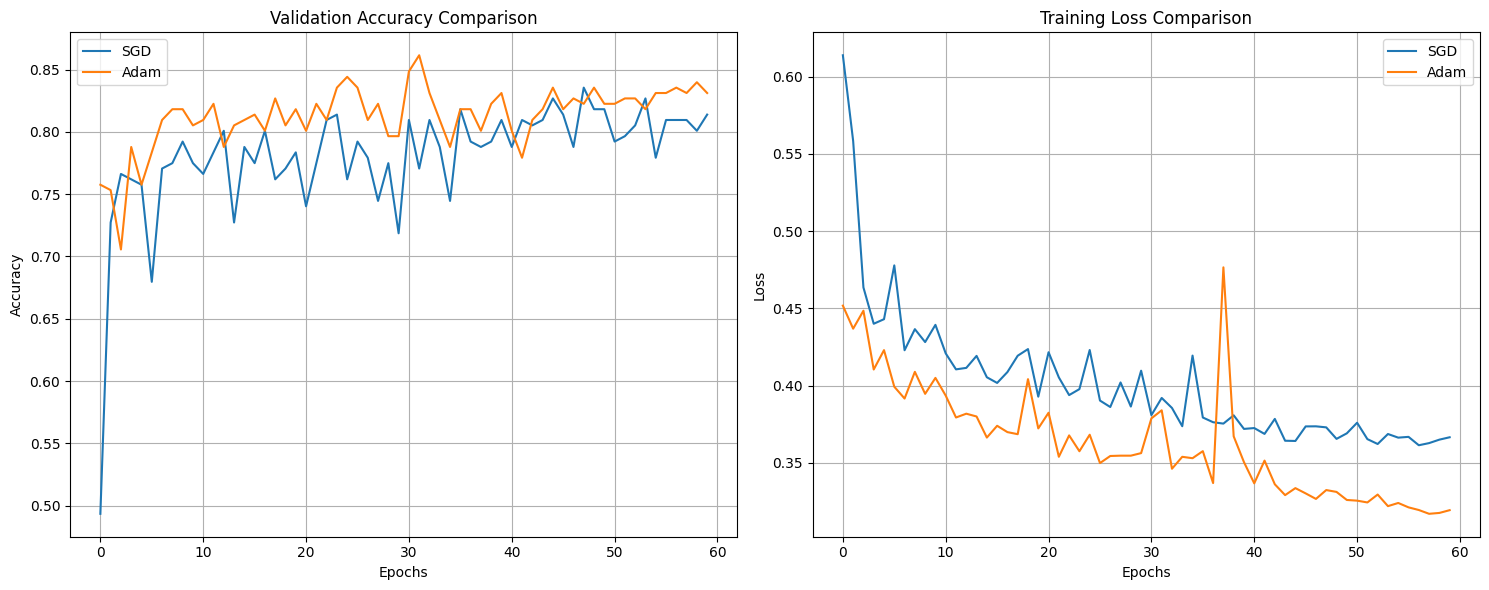

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer_configs = {
    'SGD':     lambda p: torch.optim.SGD(p, lr=0.01, momentum=0.9),
    'Adam':    lambda p: torch.optim.Adam(p, lr=0.001),
}

opt_histories = {}
models = {}

# Iterate and Train
for opt_name, opt_factory in optimizer_configs.items():
    print(f"\n--- Starting training with Optimizer = {opt_name} ---")
    model = GCNGraphClassifier(
        in_channels=20, 
        hidden_channels=128, 
        out_channels=2, 
        num_layers=3
    ).to(device)

    optimizer = opt_factory(model.parameters())
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=0.00001
    )

    models[opt_name], opt_histories[opt_name] = run_train_test(f"gcn_{opt_name}", model, optimizer, criterion, scheduler, epochs=60, return_history=True)

print("-"*30)
for model_name, _model in models.items():
    print_model_performance(model_name, _model, test_loader)

# Plotting the Results
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for name, history in opt_histories.items():
    plt.plot(history['val_acc'], label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in opt_histories.items():
    plt.plot(history['train_loss'], label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Latent Representation



In [ ]:
# Here is a Latent Representation of our best model (GCN)
# CONFIG
CACHE_FILES = [
    "dataset/twitter15_cache_binary.pt", 
    "dataset/twitter16_cache_binary.pt"
]
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 60

#DATASET LOADER
class CachedRumorDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths):
        self.data_list = []
        for path in file_paths:
            if os.path.exists(path):
                print(f"Loading cache: {path}...")
                try:
                    loaded_data = torch.load(path, weights_only=False)
                except TypeError:
                    loaded_data = torch.load(path)
                
                if isinstance(loaded_data, list):
                    self.data_list.extend(loaded_data)
                elif isinstance(loaded_data, dict) and 'data' in loaded_data:
                    self.data_list.extend(loaded_data['data'])
            else:
                print(f"Error: File not found - {path}")
        print(f"Total samples loaded: {len(self.data_list)}")

    def __len__(self): return len(self.data_list)
    def __getitem__(self, idx): return self.data_list[idx]

# MODEL CLASS (With Embeddings Extraction) 
class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()
        self.input_encoder = Sequential(
            Linear(in_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU()
        )
        self.gnn = GCN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            out_channels=hidden_channels,
            dropout=dropout
        )
        self.classifier = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch, return_embeds=False):
        x = self.input_encoder(x)
        x = self.gnn(x, edge_index)
        
        # This pooling layer creates the single vector for the whole graph
        embedding = global_mean_pool(x, batch)
        
        out = self.classifier(embedding)
        
        if return_embeds:
            return out, embedding
        return out


print(f"Using device: {DEVICE}")

# Load & Split
full_dataset = CachedRumorDataset(CACHE_FILES)
if len(full_dataset) == 0: raise ValueError("No data loaded!")

labels = [d.y.item() for d in full_dataset]
train_idx, test_idx = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42, stratify=labels)

train_loader = DataLoader([full_dataset[i] for i in train_idx], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader([full_dataset[i] for i in test_idx], batch_size=BATCH_SIZE, shuffle=False)

# Class Weights
train_labels = [full_dataset[i].y.item() for i in train_idx]
count = Counter(train_labels)
w0 = len(train_labels) / (2 * count.get(0, 1))
w1 = len(train_labels) / (2 * count.get(1, 1))
weights = torch.tensor([w0, w1], dtype=torch.float).to(DEVICE)
print(f"Weights: Non-Rumor={w0:.2f}, Rumor={w1:.2f}")

# Init Model
num_features = full_dataset[0].x.shape[1]
model = GCNGraphClassifier(in_channels=num_features, hidden_channels=128, out_channels=2, num_layers=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss(weight=weights)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Train Loop
best_acc = 0.0
print("\nStarting Training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(DEVICE)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += int(data.y.shape[0])
    
    acc = correct / total
    scheduler.step(acc)
    if acc > best_acc: best_acc = acc
    print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Test Acc: {acc:.4f} {'*' if acc == best_acc else ''}")

print(f"\nFinal Best Accuracy: {best_acc:.4f}")



Using device: cpu
Loading cache: dataset/twitter15_cache_binary.pt...
Loading cache: dataset/twitter16_cache_binary.pt...
Total samples loaded: 2308
Weights: Non-Rumor=1.99, Rumor=0.67

Starting Training...


C:\Users\aya20\AppData\Local\Temp\ipykernel_3164\3927817151.py:89: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader([full_dataset[i] for i in train_idx], batch_size=BATCH_SIZE, shuffle=True)
C:\Users\aya20\AppData\Local\Temp\ipykernel_3164\3927817151.py:90: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader([full_dataset[i] for i in test_idx], batch_size=BATCH_SIZE, shuffle=False)


Epoch 01 | Loss: 33.9562 | Test Acc: 0.7403 *
Epoch 02 | Loss: 29.0630 | Test Acc: 0.7208 
Epoch 03 | Loss: 26.6220 | Test Acc: 0.7100 
Epoch 04 | Loss: 26.2781 | Test Acc: 0.7359 
Epoch 05 | Loss: 25.6800 | Test Acc: 0.7511 *
Epoch 06 | Loss: 25.8322 | Test Acc: 0.7359 
Epoch 07 | Loss: 25.6656 | Test Acc: 0.7056 
Epoch 08 | Loss: 25.2982 | Test Acc: 0.7338 
Epoch 09 | Loss: 23.7640 | Test Acc: 0.7468 
Epoch 10 | Loss: 25.4027 | Test Acc: 0.7424 
Epoch 11 | Loss: 23.7055 | Test Acc: 0.8052 *
Epoch 12 | Loss: 23.6045 | Test Acc: 0.7511 
Epoch 13 | Loss: 23.7543 | Test Acc: 0.7792 
Epoch 14 | Loss: 24.9316 | Test Acc: 0.7771 
Epoch 15 | Loss: 22.3850 | Test Acc: 0.8009 
Epoch 16 | Loss: 22.6341 | Test Acc: 0.8009 
Epoch 17 | Loss: 22.9420 | Test Acc: 0.7944 
Epoch 18 | Loss: 22.5316 | Test Acc: 0.8117 *
Epoch 19 | Loss: 21.9130 | Test Acc: 0.8030 
Epoch 20 | Loss: 22.5291 | Test Acc: 0.8009 
Epoch 21 | Loss: 22.2429 | Test Acc: 0.8139 *
Epoch 22 | Loss: 22.7206 | Test Acc: 0.8117 
Epoch


Generating Latent Space Plot (t-SNE)...


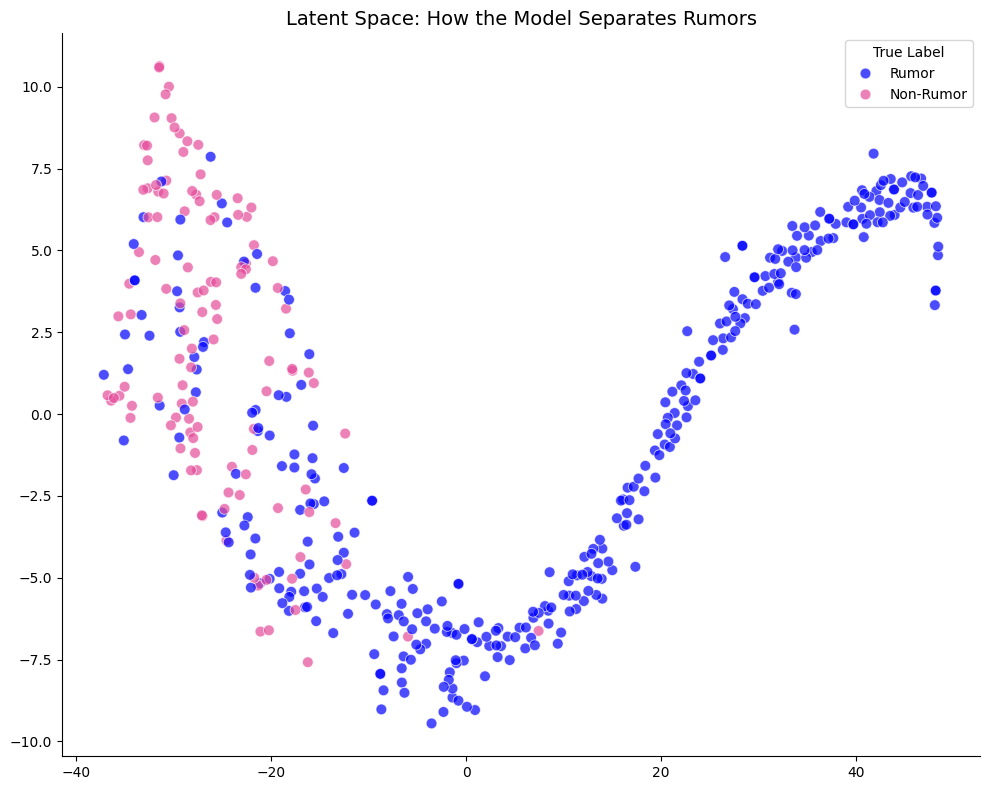

In [ ]:
# VISUALIZATION FUNCTION
def visualize_latent_space(model, loader, device):
    print("\nGenerating Latent Space Plot (t-SNE)...")
    model.eval()
    all_embeds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            _, embeds = model(data.x, data.edge_index, data.batch, return_embeds=True)
            all_embeds.append(embeds.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
            
    X = np.concatenate(all_embeds, axis=0)
    y = np.concatenate(all_labels, axis=0)
    
    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    X_2d = tsne.fit_transform(X)
    
    # Plot
    plt.figure(figsize=(10, 8))
    label_map = {0: 'Non-Rumor', 1: 'Rumor'}
    y_names = [label_map[label] for label in y]
    
    sns.scatterplot(
        x=X_2d[:, 0], y=X_2d[:, 1], hue=y_names, 
        palette=["blue", '#e54c9b'], alpha=0.7, s=60
    )
    plt.title('Latent Space: How the Model Separates Rumors', fontsize=14)
    plt.legend(title='True Label')
    sns.despine()
    plt.tight_layout()
    plt.show()
    
visualize_latent_space(model, test_loader, DEVICE)